# Apoorv Try

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

In [61]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [62]:
from scipy.spatial.distance import cdist

def get_decision_boundary(f_xx, f_yy, prior):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    classes = prior.classify(torch.from_numpy(f_points).float()).detach().numpy()
    return classes

In [63]:
def get_decision_boundary_logit(f_xx, f_yy, prior):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    classes = prior.class_logits(torch.from_numpy(f_points).float()).detach().numpy()
    return classes

In [266]:
def get_means(n_classes, r):
    phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
    mean_x = np.cos(phis) * r
    mean_y = np.sin(phis) * r
    means = np.hstack([mean_x[:, None], mean_y[:, None]])
    means = torch.from_numpy(means).float()
    return means

In [285]:
r = 3.5
means = torch.tensor([[-r, -r], [r, r]])
# why does decresing the value of r give an error here?
# r = 3.5
# n_classes = 2
# means = get_means(n_classes, r)

prior = SSLGaussMixture(means=means)
noise_ip = 0.05
data, labels = make_moons_ssl(noise_ip)
flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)
loss_fn = FlowLoss(prior)

In [286]:
lr_init = 1e-4
epochs = 2001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

In [287]:

grid_points = 150
grid_freq = 10
z_lims = np.array([-7.5, 7.5])
x_lims = np.array([-1.5, 2.5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)



In [293]:
all_probs=[]
all_class_logit = []
for ensemble in range(10):
    flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)
    loss_fn = FlowLoss(prior)
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
    for t in range(epochs):  
        batch_idx = np.random.choice(n_ul, size=batch_size)
        batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
        batch_x = np.vstack([batch_x, labeled_data])
        batch_y = np.hstack([batch_y, labeled_labels])
        batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
        z = flow(batch_x)
        sldj = flow.logdet()

        loss = loss_fn(z, sldj, batch_y)
    
        optimizer.zero_grad()
        loss.backward()#retain_graph=True)
        optimizer.step()
    
        if t % print_freq == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)
        
        if t == int(epochs * 0.5) or t == int(epochs * 0.8):
            for p in optimizer.param_groups:
                p["lr"] /= 10
    
    f_xx, f_yy = grid_image(flow, xx_x, yy_x)
    classes = get_decision_boundary_logit(f_xx, f_yy, prior)
    all_class_logit.append(classes)
    inv = flow(torch.from_numpy(data)).detach().numpy()
    all_probs.append(inv)



/home/savs95/flowgmm/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 23.072
iter 500: loss = 11.498
iter 1000: loss = 11.396
iter 1500: loss = 11.066
iter 2000: loss = 11.019


/home/savs95/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


iter 0: loss = 22.476
iter 500: loss = 11.809
iter 1000: loss = 11.429
iter 1500: loss = 11.189
iter 2000: loss = 10.875
iter 0: loss = 23.555
iter 500: loss = 10.849
iter 1000: loss = 11.756
iter 1500: loss = 11.057
iter 2000: loss = 10.905
iter 0: loss = 22.762
iter 500: loss = 11.762
iter 1000: loss = 10.801
iter 1500: loss = 10.656
iter 2000: loss = 10.723
iter 0: loss = 23.734
iter 500: loss = 11.085
iter 1000: loss = 11.293
iter 1500: loss = 10.768
iter 2000: loss = 11.293
iter 0: loss = 22.729
iter 500: loss = 11.034
iter 1000: loss = 11.052
iter 1500: loss = 10.900
iter 2000: loss = 10.701
iter 0: loss = 23.654
iter 500: loss = 11.296
iter 1000: loss = 11.162
iter 1500: loss = 10.800
iter 2000: loss = 11.436
iter 0: loss = 22.151
iter 500: loss = 11.961
iter 1000: loss = 11.589
iter 1500: loss = 11.103
iter 2000: loss = 11.925
iter 0: loss = 22.699
iter 500: loss = 11.608
iter 1000: loss = 10.656
iter 1500: loss = 10.797
iter 2000: loss = 10.641
iter 0: loss = 23.421
iter 500: 

In [294]:
all_prob = np.array(all_probs)    
all_class = np.array(all_class_logit)

In [295]:
inv_nice = all_prob.mean(0)
all_class_mean = all_class.mean(0)
all_class_mean.shape

(22500, 2)

In [296]:
all_class_mean_argmax = np.argmax(all_class_mean, axis = 1)

(-1.5, 2.5)

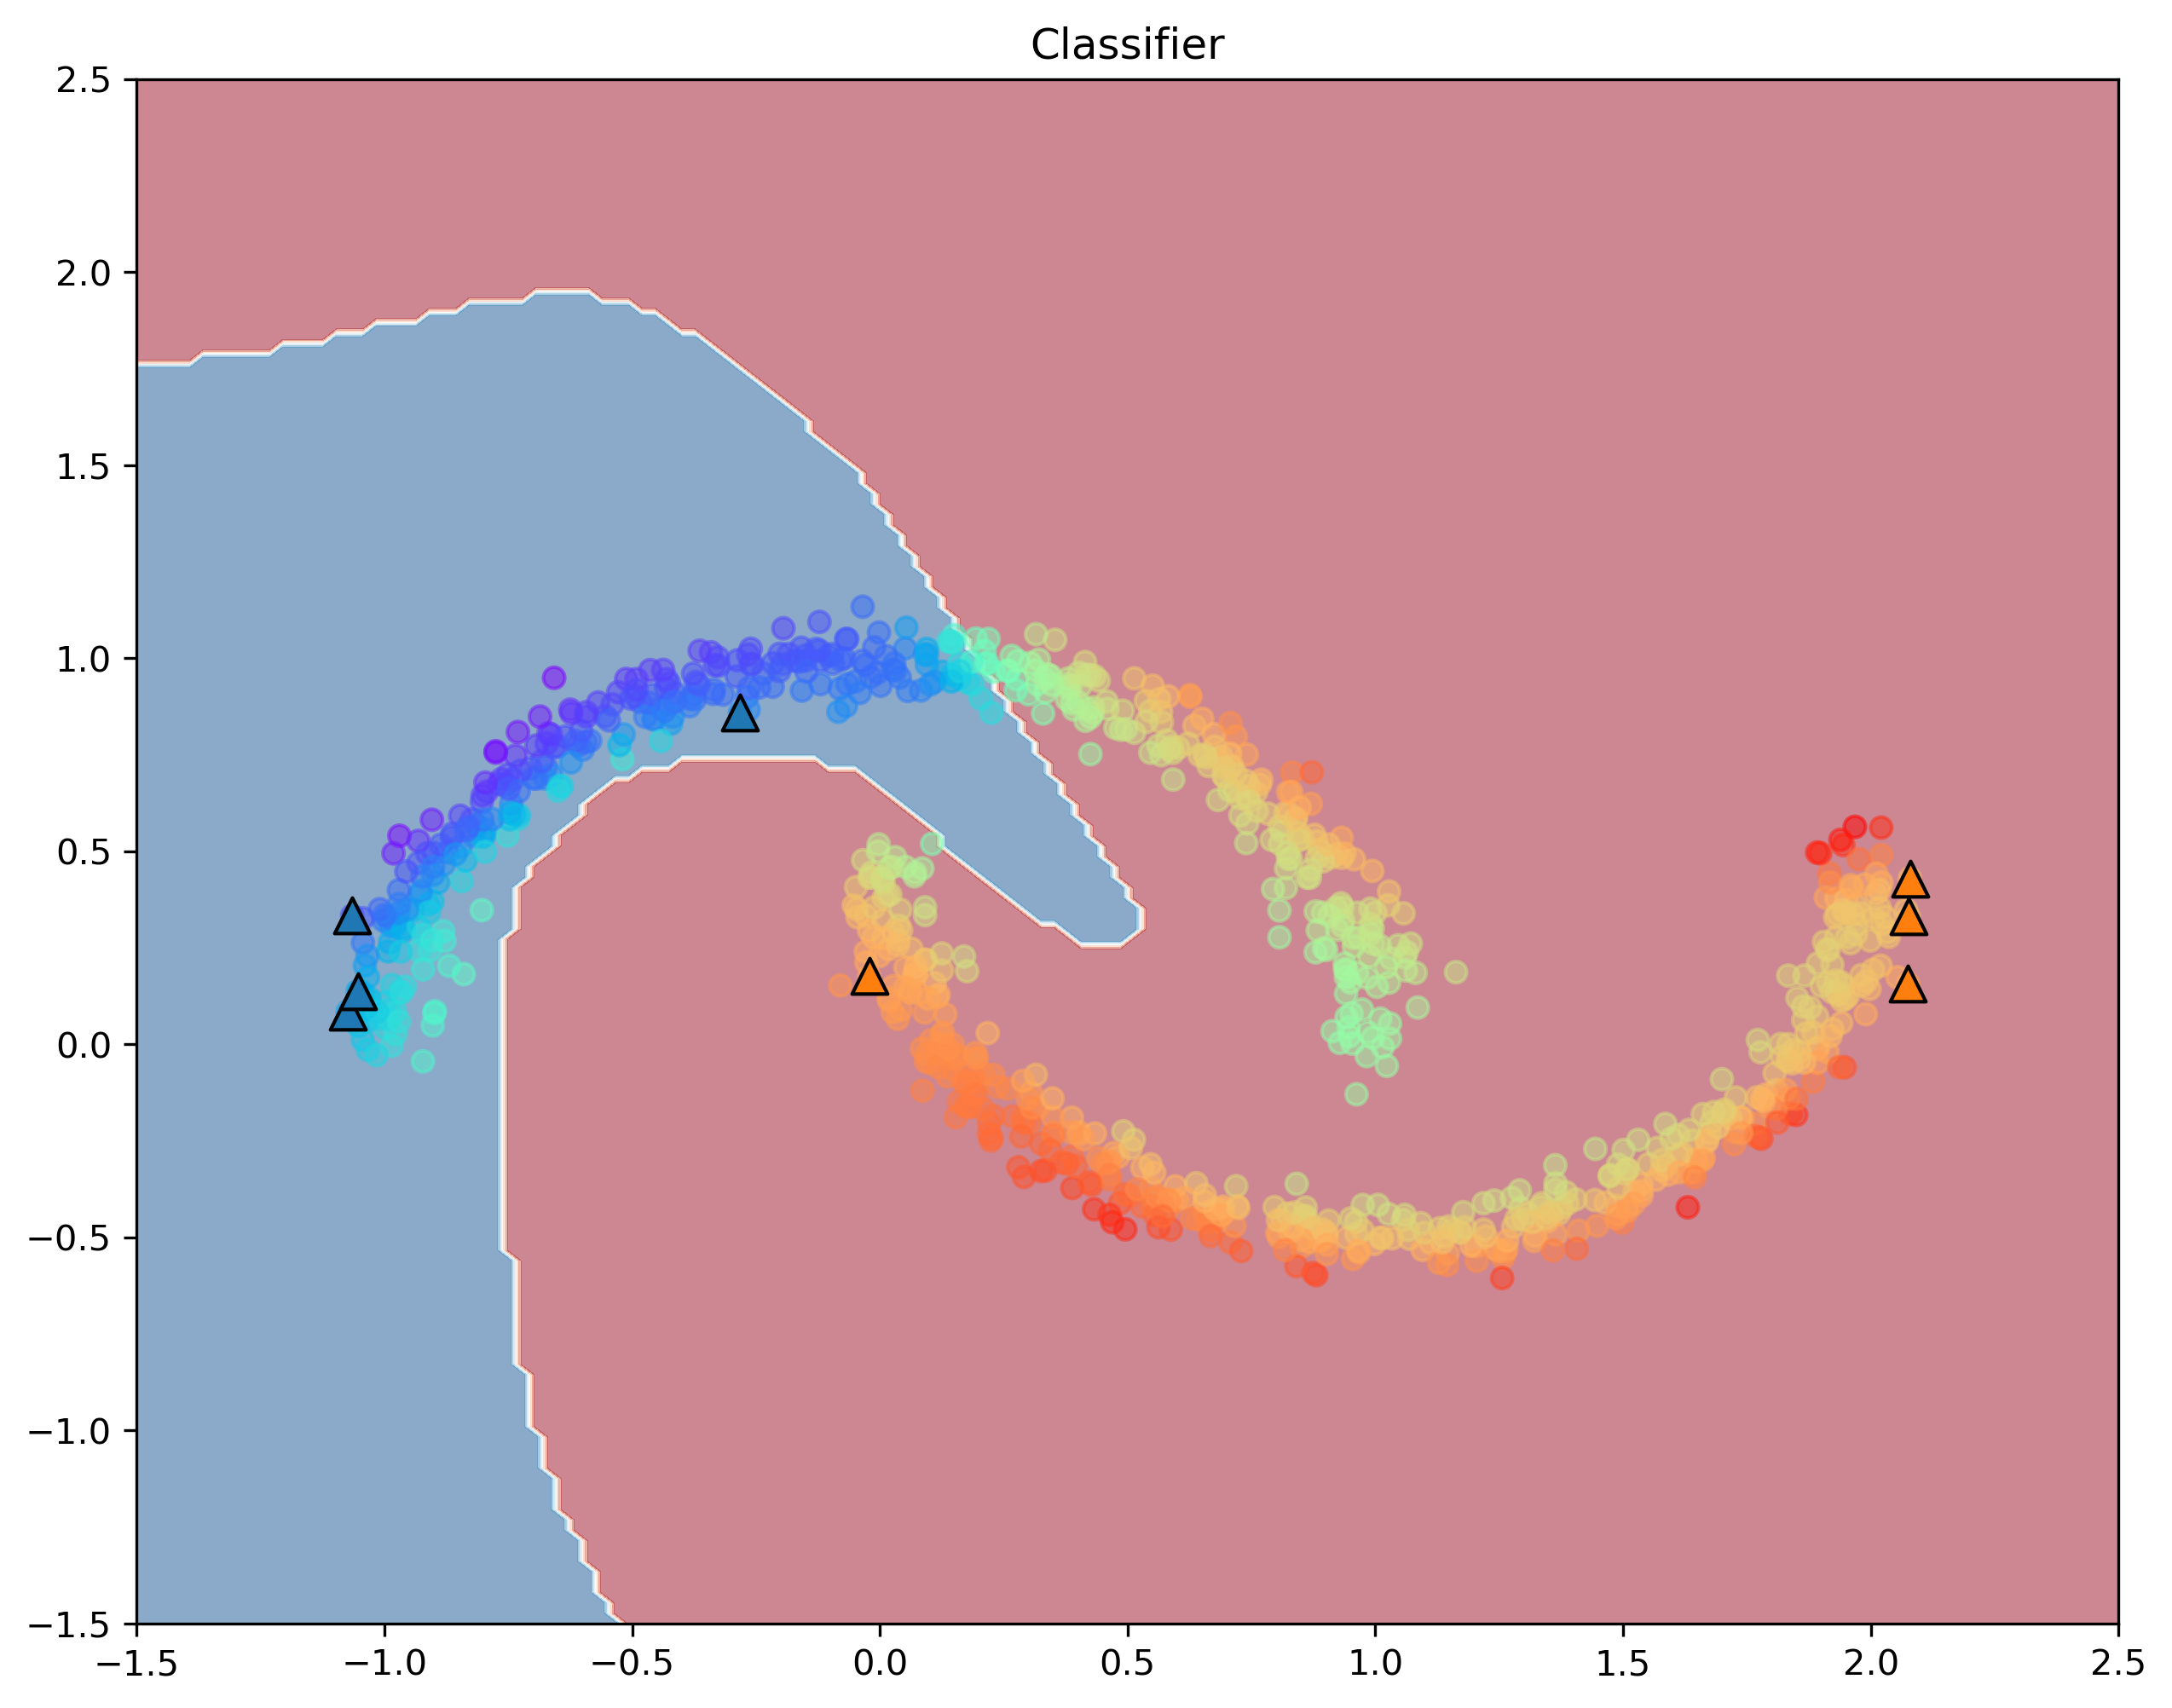

In [274]:
plt.figure


(-1.5, 2.5)

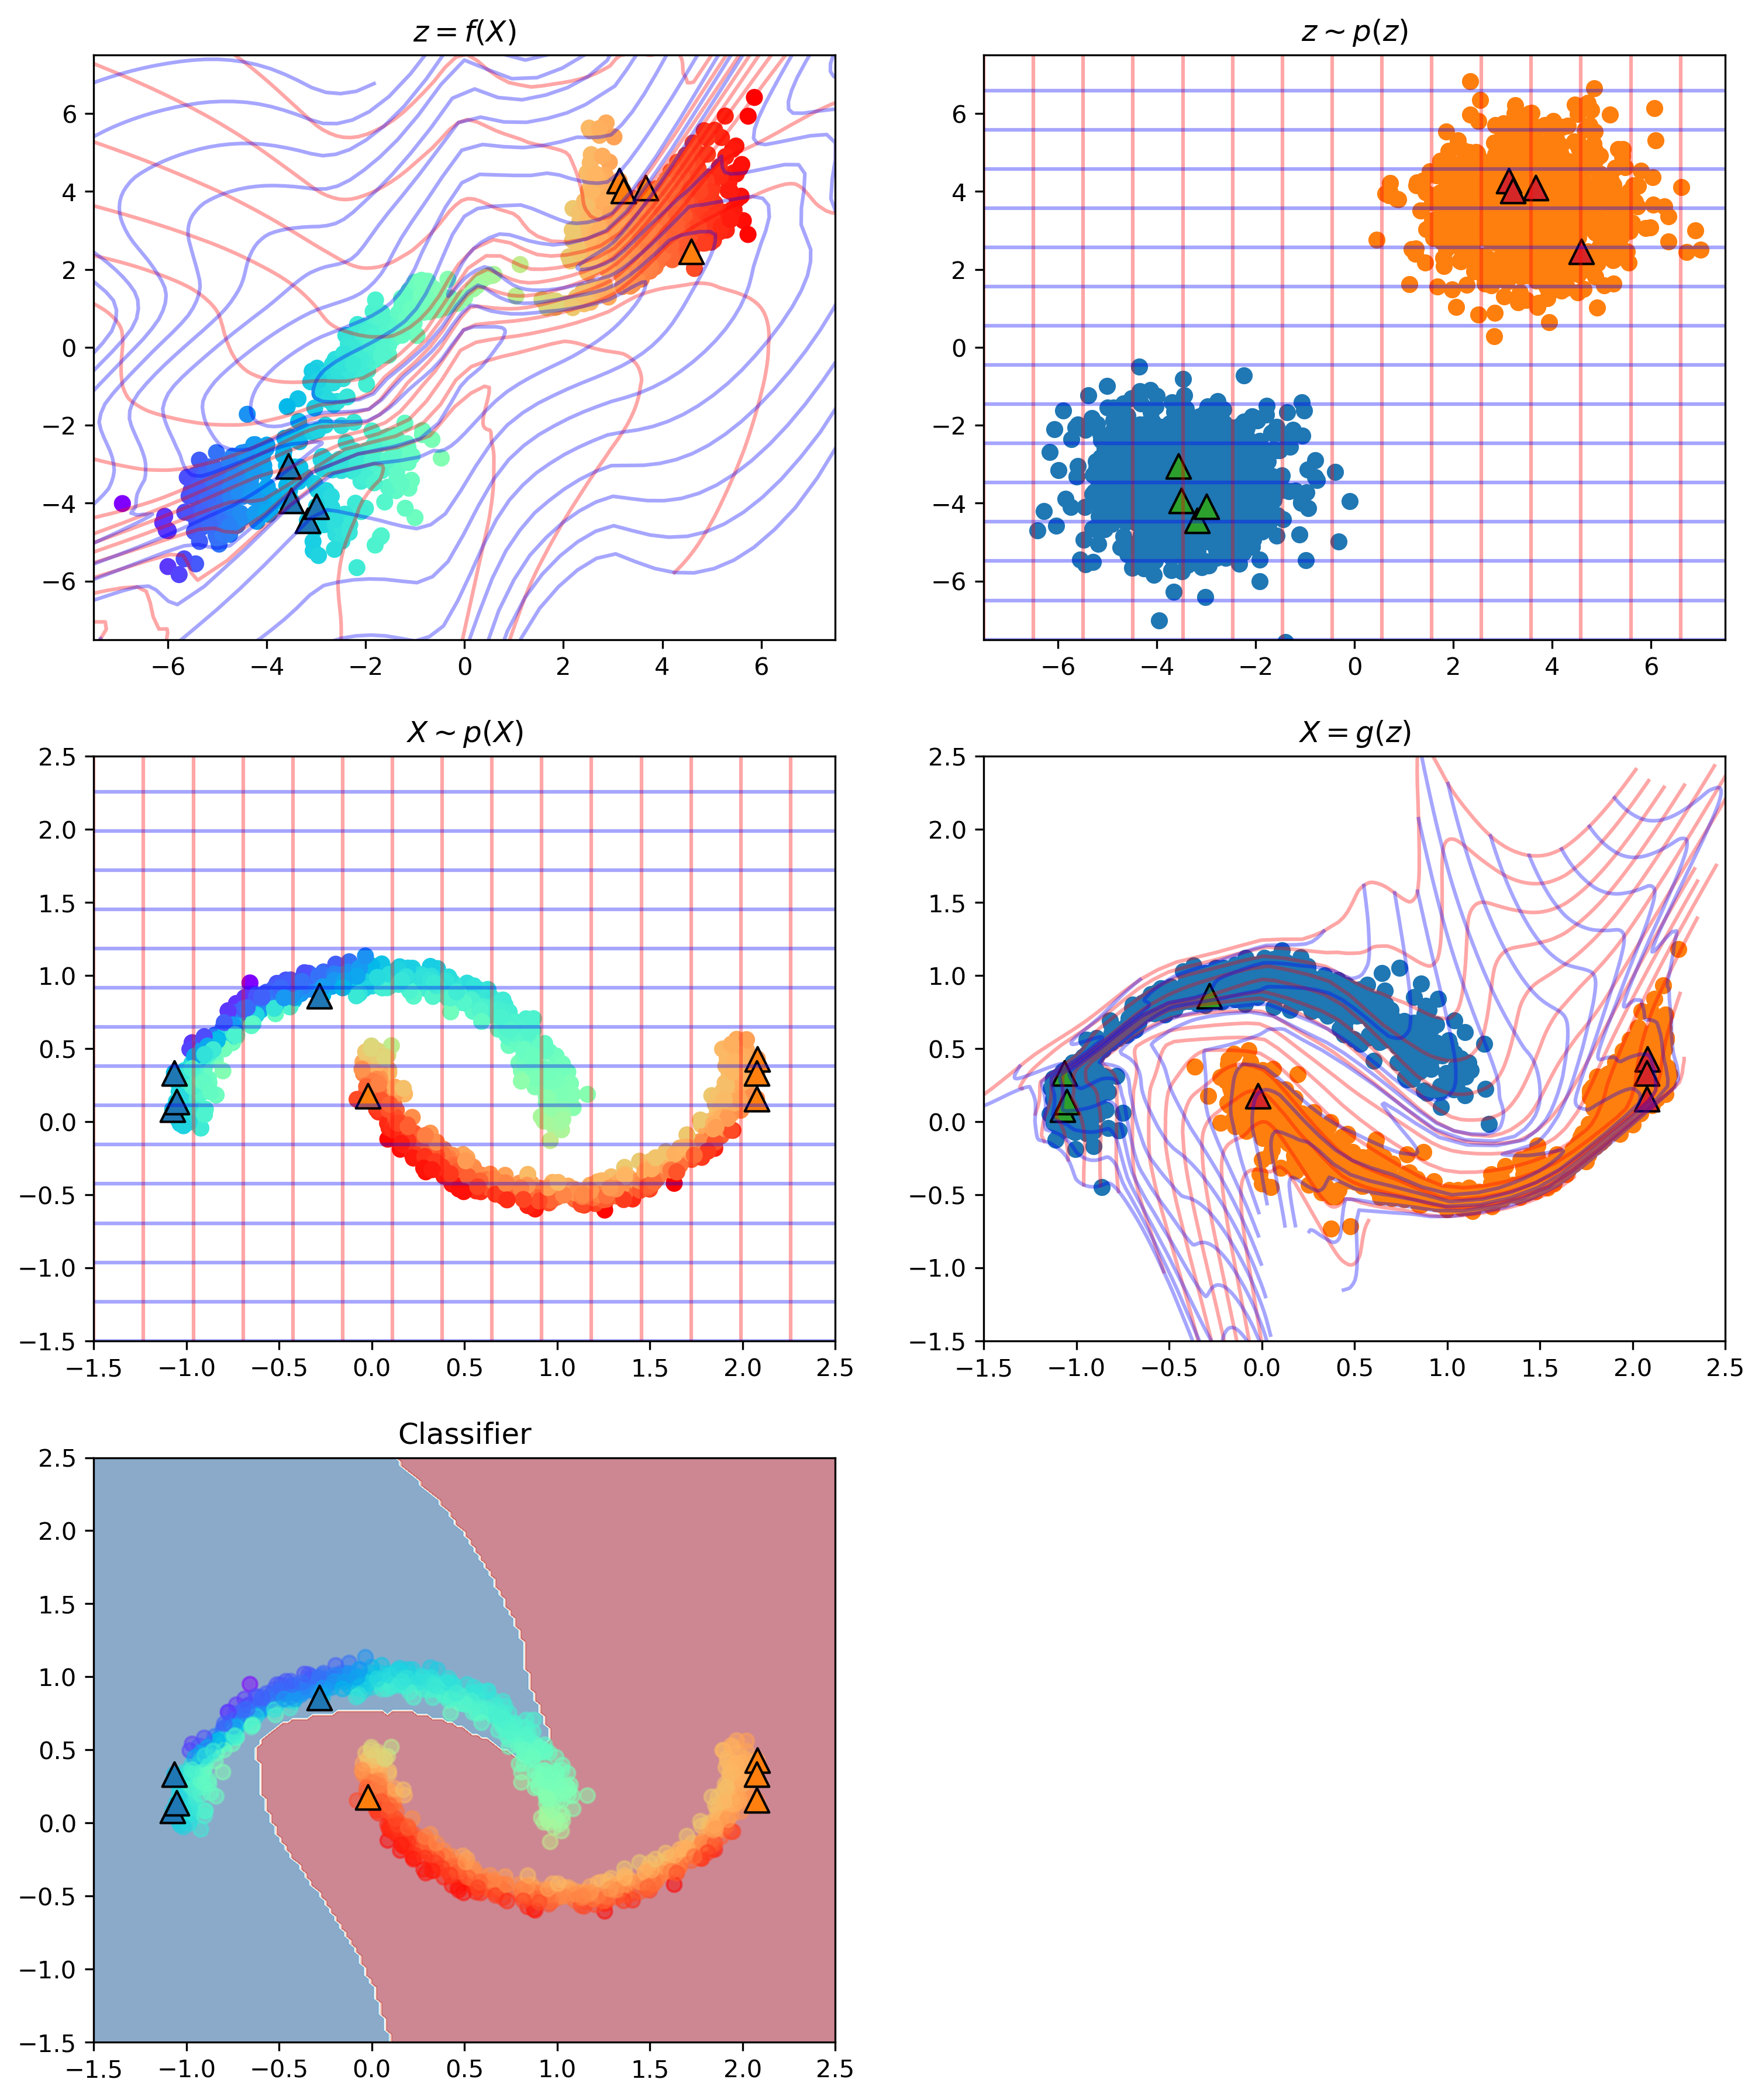

In [297]:
plt.figure(figsize=(12, 15))


grid_points = 150
grid_freq = 10
z_lims = np.array([-7.5, 7.5])
x_lims = np.array([-1.5, 2.5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

#inv_nice = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv_nice[:, 0], inv_nice[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv_nice[labels==i][:, 0], inv_nice[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv_nice[labels==i][:, 0], inv_nice[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
plt.contourf(xx_x, yy_x, all_class_mean_argmax.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)
#classes = get_decision_boundary(f_xx, f_yy, prior)
#plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
#plt.scatter(data[:, 0], data[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
#for i in range(int(np.max(labels) + 1)):
#    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
#plt.title(r'Classifier')
#plt.xlim(x_lims)
#plt.ylim(x_lims)

In [62]:
inv_nice = all_prob[3]

/home/savs95/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


(-1.5, 2.5)

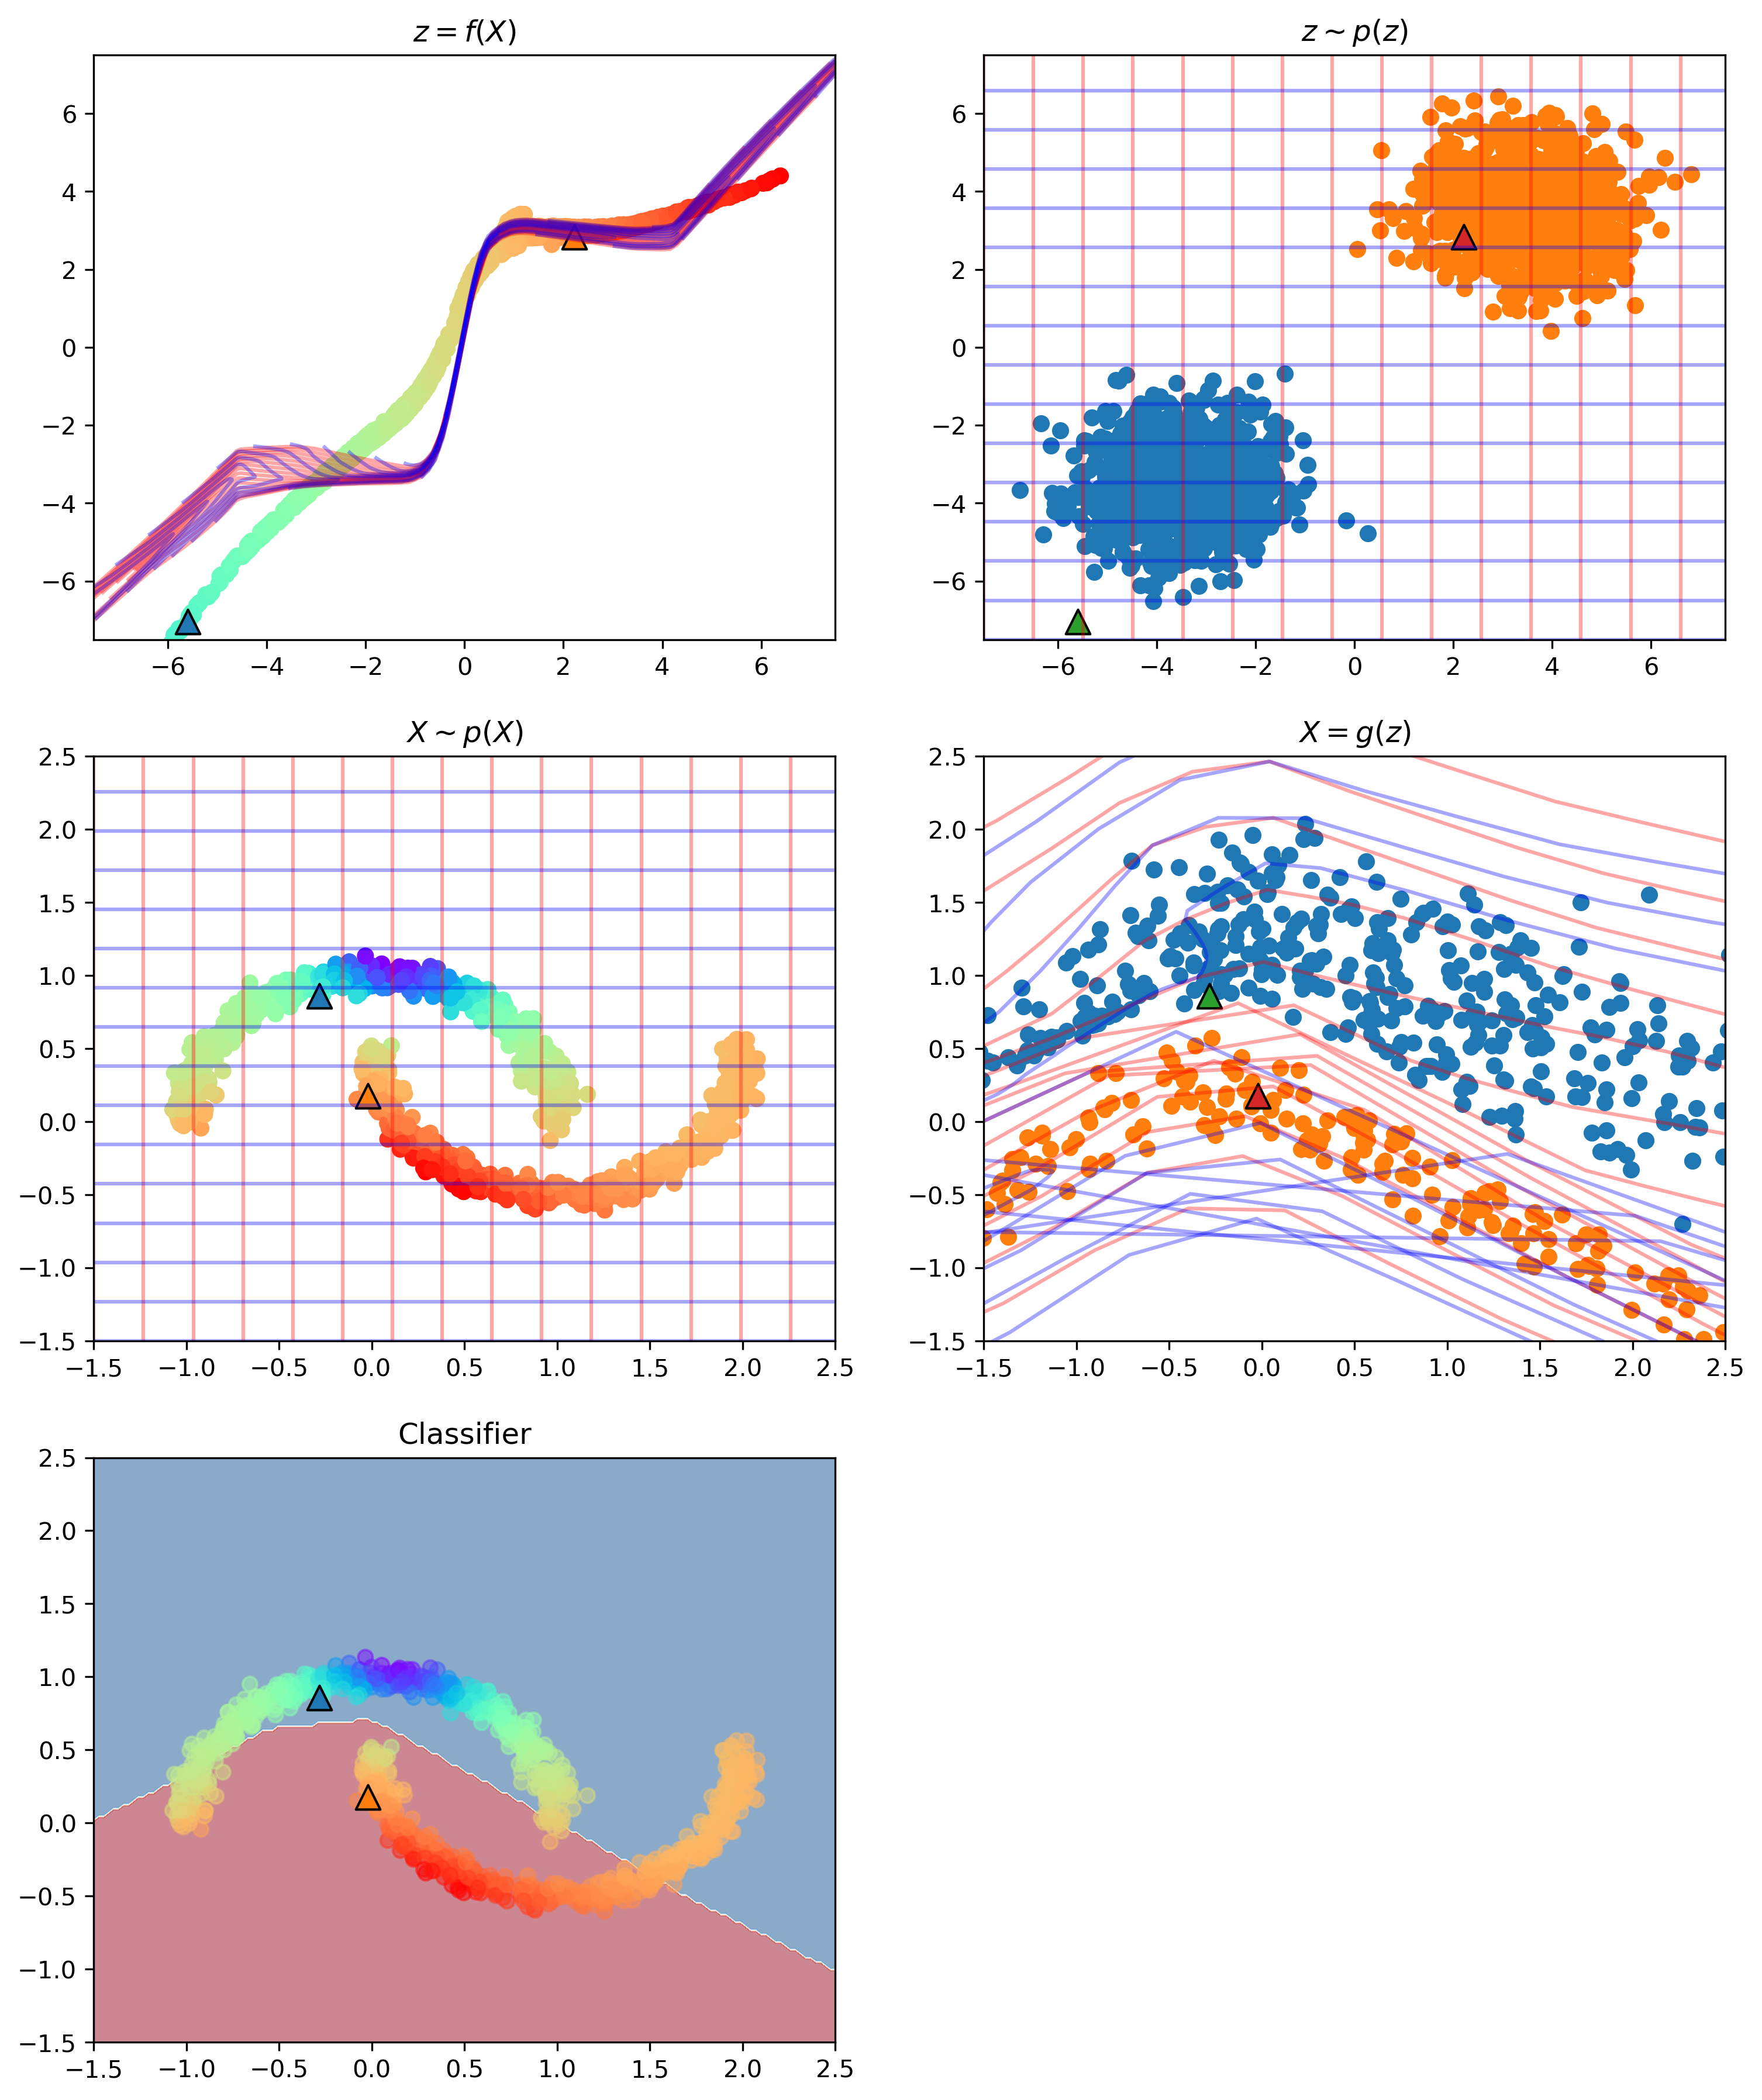

In [63]:
plt.figure(figsize=(12, 15))


grid_points = 150
grid_freq = 10
z_lims = np.array([-7.5, 7.5])
x_lims = np.array([-1.5, 2.5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

#inv_nice = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv_nice[:, 0], inv_nice[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv_nice[labels==i][:, 0], inv_nice[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv_nice[labels==i][:, 0], inv_nice[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv_nice[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

In [ ]:
n_ens = 50
n_steps = 20000
n_data = len(y)

de_all_preds = []
for i in range(n_ens):

    net = RegNet(dimensions=[10, 10, 10], input_dim=2)
    optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
    criterion = torch.nn.functional.mse_loss
    noise_var = 0.0005
    prior_var = 100

    for epoch in range(n_steps):
        optimizer.zero_grad()
        preds = net(f)
        loss = criterion(preds, y) / (2 * noise_var)
        loss += prior(net, prior_var) / n_data 
        loss.backward()
        optimizer.step()

    preds = net(f_).data.numpy()[None, :]
    de_all_preds.append(preds.copy())

de_all_preds = np.vstack(de_all_preds)

### Dataset Make Moon
```python
idx1 = [3]# 1,3, 4, 5]#, 9, 11, 14, 16]
labels[idx1] = 1
idx0 = [2]#7, 2, 6, 7, 10, 17]#, 19, 34, 13, 15]
labels[idx0] = 0
```
In this particular label settings, using deep ensemble might be useful